In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
def load_sample(data_dir):
    data = np.load(data_dir)
    return pd.DataFrame(data)

def load_all_samples(data_dir):
    data = []
    for file in os.listdir(data_dir):
        if file.endswith(".labels.npy"):
            continue
        if file.endswith(".npy"):
            data.append(load_sample(os.path.join(data_dir, file)))
    return pd.concat(data, axis=0)

def load_data(data_dir):
    return load_all_samples(data_dir)

In [3]:
data = []
for folder in os.listdir('./dataset'):
    if os.path.isfile(os.path.join('./dataset', folder)):
        continue
    data.append(load_data(os.path.join('./dataset', folder)))
master_data = np.stack(data, axis=0)

In [4]:
master_data_pd = master_data.reshape(master_data.shape[0]*master_data.shape[1], -1)
master_data_pd = pd.DataFrame(master_data_pd)
with open('./dataset/feature_names.txt', 'r') as f:
    feature_names = f.read().splitlines()
master_data_pd.columns = feature_names

In [5]:
corr = master_data_pd.corr()

In [6]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, corr_matr, n=5):
    au_corr = corr_matr.abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

pd.set_option('display.max_rows', None)
print("Top Absolute Correlations")
get_top_abs_correlations(master_data_pd, corr, 500)


Top Absolute Correlations


cln_power_mean        cln_power_std           0.994159
cln_flux_mean         cln_energy_mean         0.994124
cln_flux_std          cln_energy_std          0.993975
raw_melspect_mean_57  raw_melspect_mean_58    0.993359
raw_melspect_mean_58  raw_melspect_mean_59    0.990840
raw_mfcc_d_mean_19    cln_mfcc_d_mean_19      0.990565
raw_mfcc_d_mean_18    cln_mfcc_d_mean_18      0.989986
raw_mfcc_d_mean_11    cln_mfcc_d_mean_11      0.988670
raw_mfcc_d2_mean_19   cln_mfcc_d2_mean_19     0.987990
raw_mfcc_d_mean_12    cln_mfcc_d_mean_12      0.987962
raw_mfcc_d_mean_17    cln_mfcc_d_mean_17      0.987906
raw_mfcc_d2_mean_18   cln_mfcc_d2_mean_18     0.987304
raw_mfcc_d_mean_14    cln_mfcc_d_mean_14      0.987277
raw_mfcc_d_mean_13    cln_mfcc_d_mean_13      0.987192
raw_mfcc_d_mean_9     cln_mfcc_d_mean_9       0.987187
raw_mfcc_d_mean_16    cln_mfcc_d_mean_16      0.987181
raw_melspect_mean_56  raw_melspect_mean_57    0.986361
raw_mfcc_d_mean_15    cln_mfcc_d_mean_15      0.986198
raw_mfcc_d

Number of principal components needed to cover 95.0% explained variance: 156


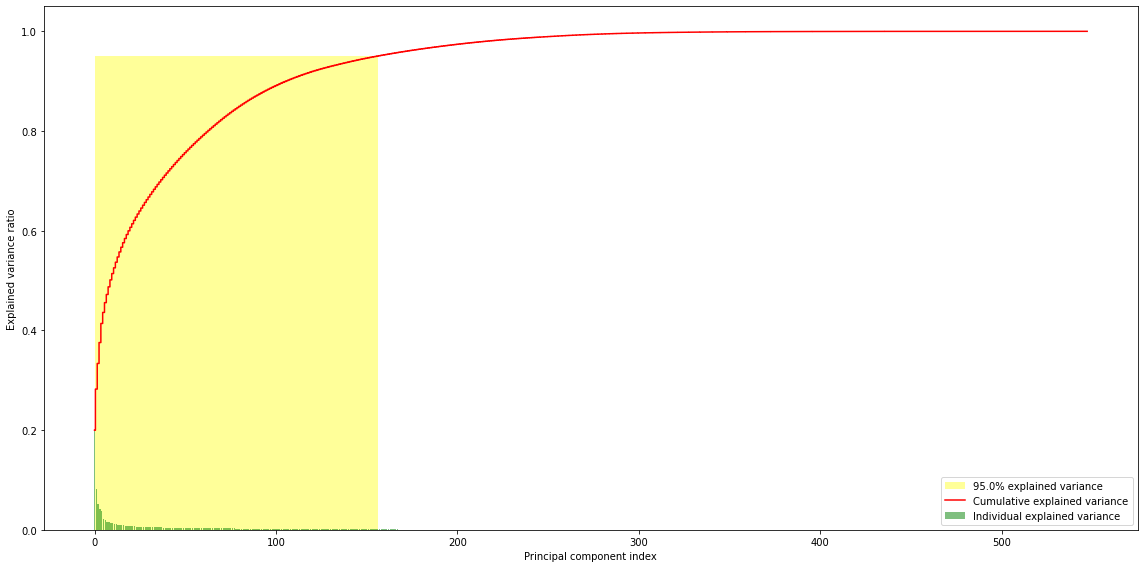

In [8]:
from sklearn.preprocessing import StandardScaler
X = master_data_pd.values
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

# Determine covariance matrix
cov_matrix = np.cov(X_std, rowvar=False)

# Determine eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Determine explained variance
total_eigenvalues = sum(eigenvalues)
var_exp = [(i/total_eigenvalues) for i in sorted(eigenvalues, reverse=True)]

cum_sum_exp = np.cumsum(var_exp)
desired_cum_var_exp = 0.95
nr_pc = 0
for i in range(cum_sum_exp.shape[0]):
    if cum_sum_exp[i] >= desired_cum_var_exp:
        nr_pc = i
        break
print('Number of principal components needed to cover ' + str(desired_cum_var_exp*100) + '% explained variance: ' + str(nr_pc))
fig = plt.figure() 
fig.set_figheight(8)
fig.set_figwidth(16)

rectangle = plt.Rectangle((0,0), nr_pc, cum_sum_exp[nr_pc], fill=True, fc='yellow', alpha=0.4, label=str(desired_cum_var_exp*100) + '% explained variance')
plt.gca().add_patch(rectangle)
plt.bar(range(0,len(var_exp)), var_exp, color='green',  alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, color='red', where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<AxesSubplot:>

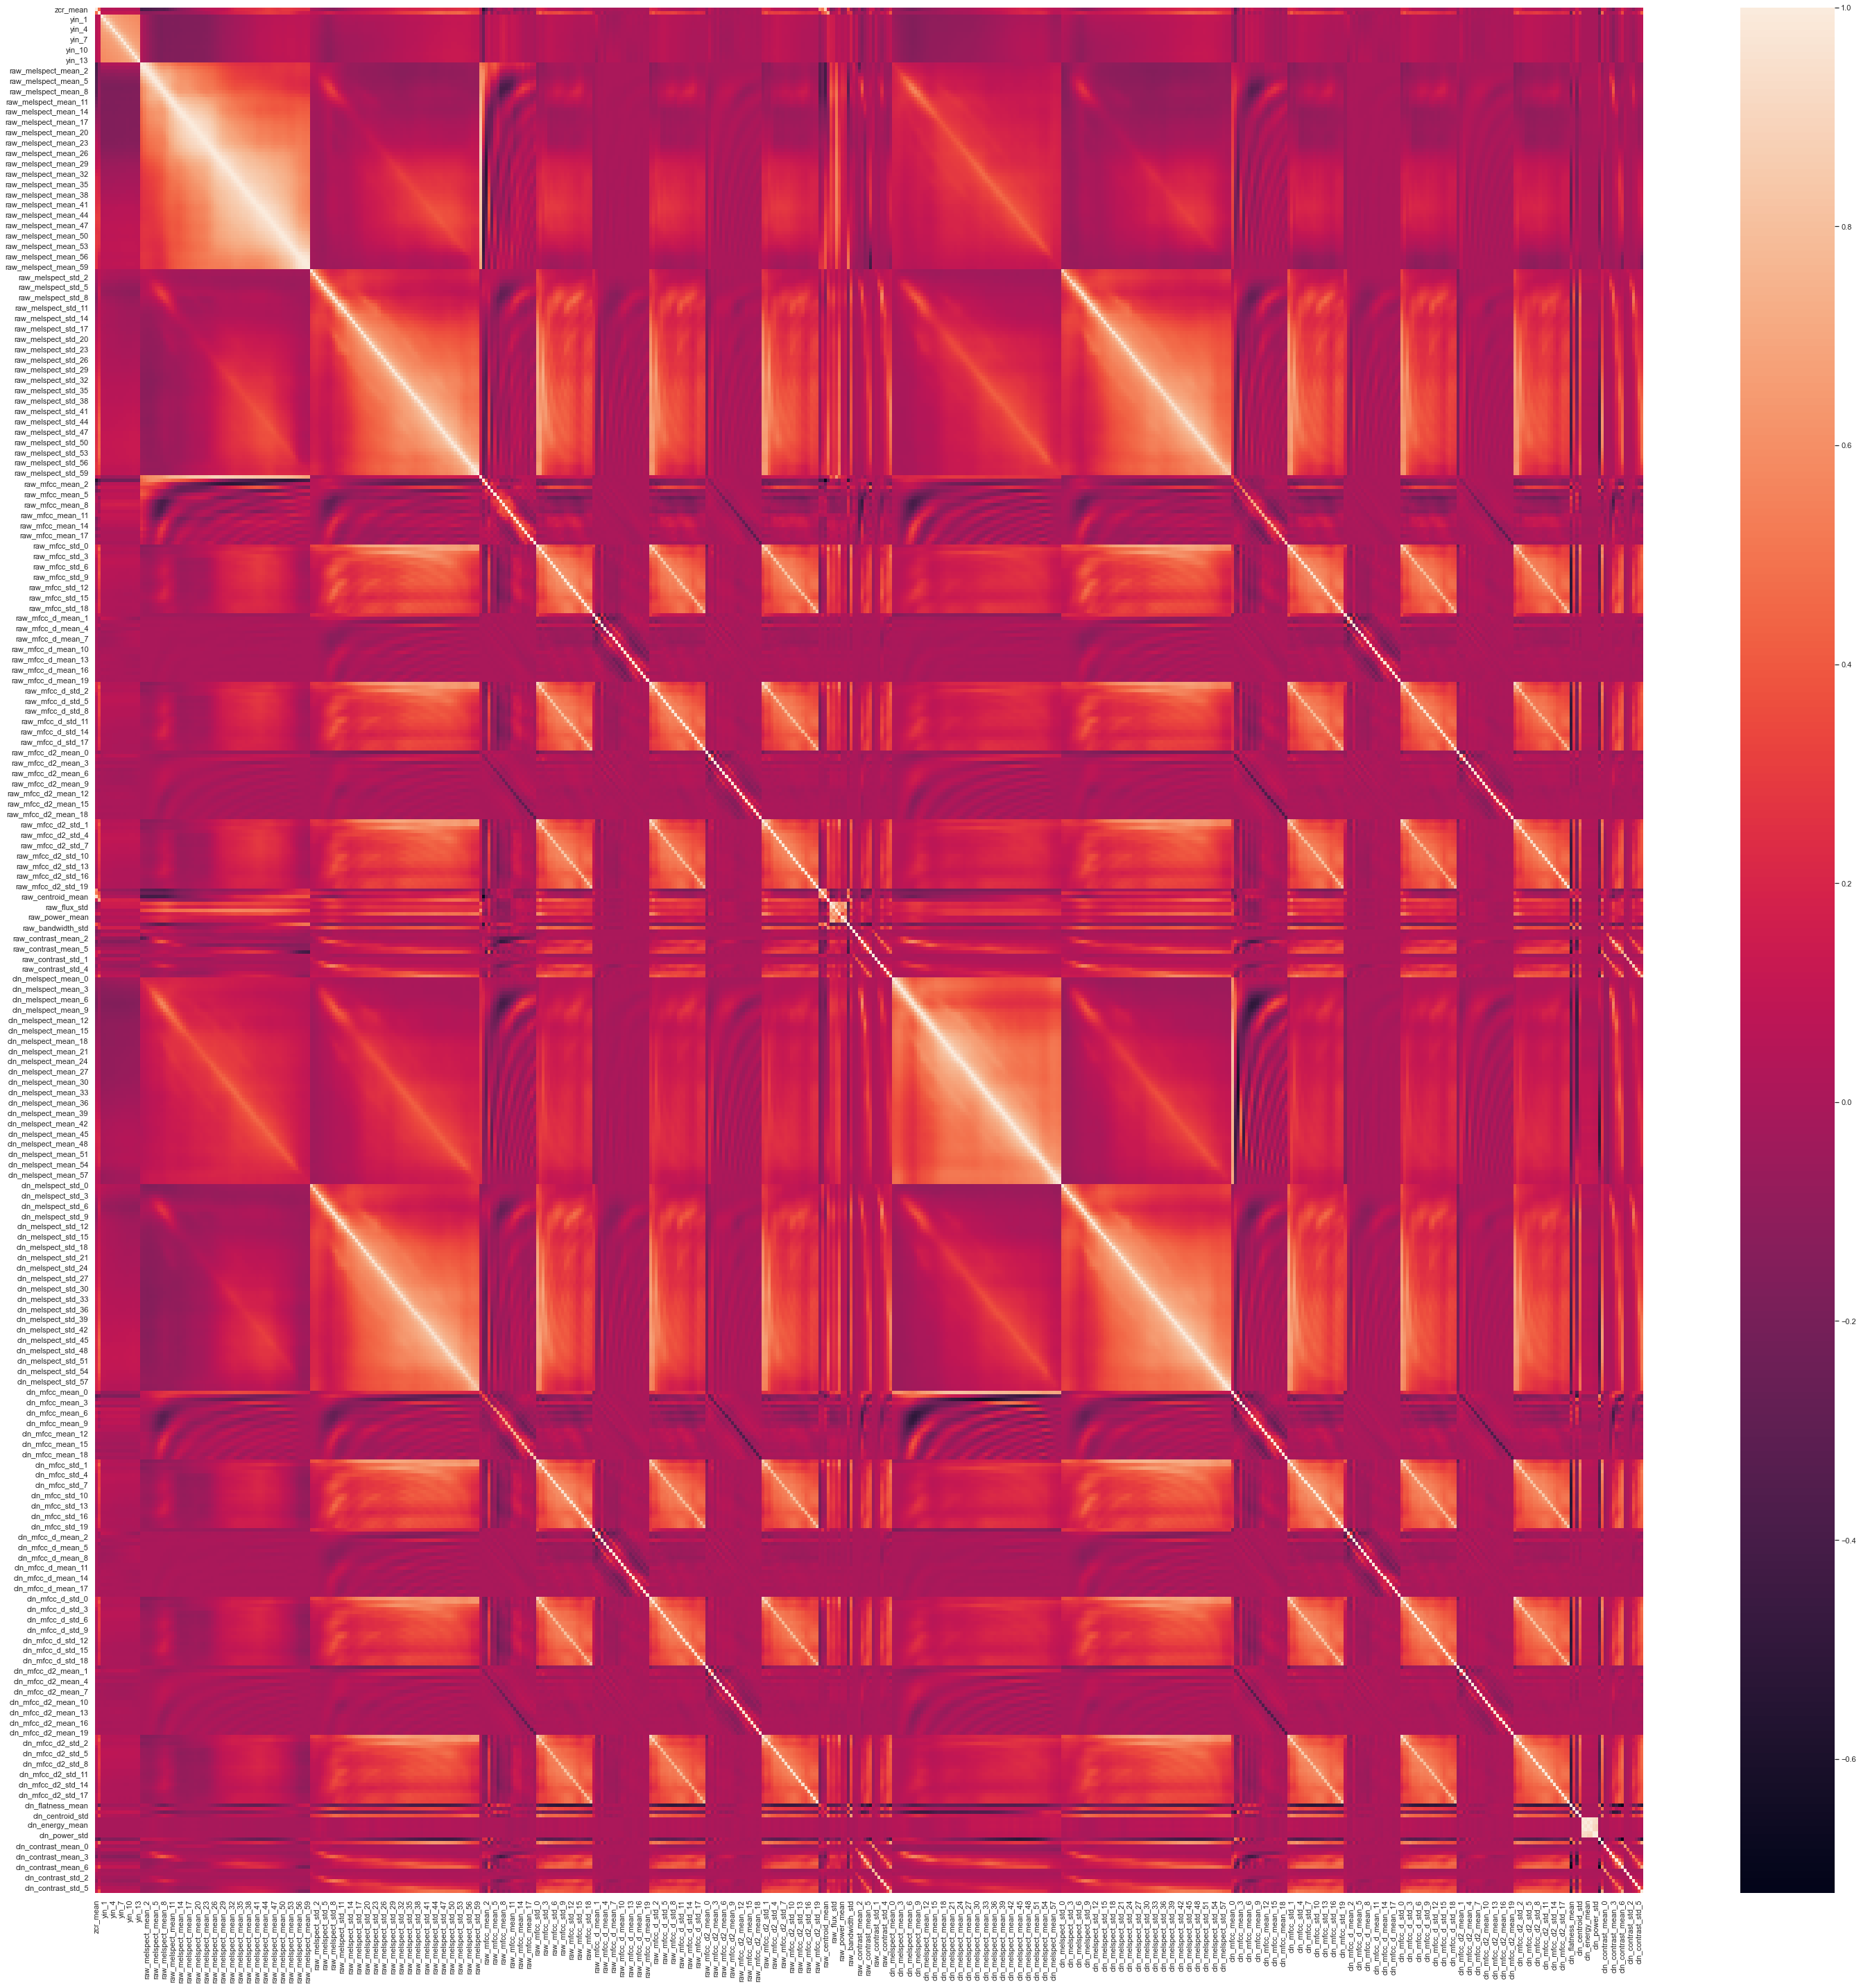

In [9]:
sns.set(rc={'figure.figsize':(50,50)})
sns.heatmap(corr, annot=False)

Some closely related / redundant subsets fo features:
    yin_xx            <->  yin_yy
    cln_flux_mean     <->  cln_energy_mean
    cln_flux_std      <->  cln_energy_std
    cln_melspect_std  <->  raw_melsplect_std
    cln_mfcc_std      <->  raw_mfcc_std
    cln_mfcc_d_mean   <->  raw_mfcc_d_mean
    cln_mfcc_d2_mean  <->  raw_mfcc_d2_mean
    cln_mfcc_d2_std   <->  raw_mfcc_d2_std
    cln_mfcc_std      <->  cln_mfcc_d_std
    cln_mfcc_std      <->  cln_mfcc_d2_std
    cln_mfcc_d_std    <->  cln_mfcc_d2_std